In [66]:
import numpy as np
import healpy as hp
from orphics import io, cosmology, maps
from pixell import enmap, curvedsky
import symlens as s
from symlens import utils
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
import sys
sys.path.append('../')
import tools
import params as m

In [9]:
lensed_cmb_file = '../maps/Colin/original/Sehgalsimparams_healpix_4096_KappaeffLSStoCMBfullsky_phi_SimLens_Tsynfastnopell_fast_lmax8000_nside4096_interp2.5_method1_1_lensed_map.fits'

In [10]:
lensed_cmb = hp.read_map(lensed_cmb_file)

/global/homes/h/hongbo/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [39]:
cmb_alms_file = m.cmb_alms_file
map_source = m.map_source
ksz_type = m.ksz_type
decmax = m.decmax
width_deg = m.width_deg
px_arcmin = m.px_arcmin
band_shape, band_wcs = enmap.band_geometry(dec_cut=np.deg2rad(decmax),
                                           res=np.deg2rad(px_arcmin / 60.))
band_modlmap = enmap.modlmap(band_shape, band_wcs)
npix = int(width_deg * 60 / px_arcmin)
ntiles = int(np.prod(band_shape) / npix**2)
num_x = int(360 / width_deg)

In [42]:
nlev_t = 10
beam_arcmin = 1
ellmin = 30
ellmax = 3000
delta_L = 100
Lmin, Lmax = ellmin, ellmax
ells = np.arange(0, ellmax+1, 1)

In [24]:
cmb_alms = hp.read_alm(cmb_alms_file)
cmb = curvedsky.alm2map(cmb_alms, enmap.empty(band_shape, band_wcs))

In [49]:
Cl_noise_TT = (nlev_t * np.pi / 180. / 60.)**2 * np.ones(ells.shape)/utils.gauss_beam(ells, beam_arcmin)**2
# noise band map
noise = curvedsky.rand_map(band_shape, band_wcs, Cl_noise_TT)

In [50]:
cmb_cut = cmb[0:npix, 0:npix]
noise_cut = noise[0:npix, 0:npix]

In [51]:
type(cmb_cut)

pixell.enmap.ndmap

<Figure size 720x216 with 0 Axes>

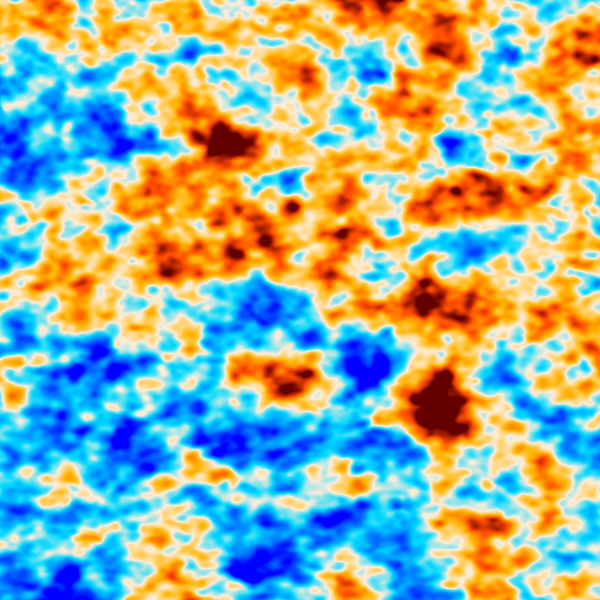

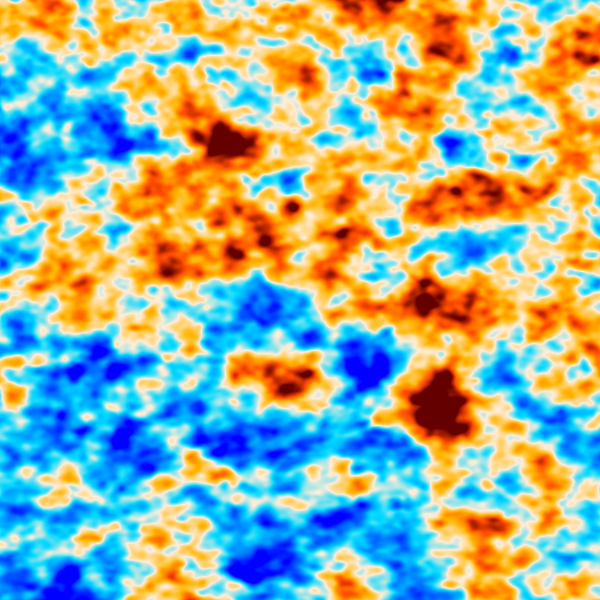

<Figure size 720x216 with 0 Axes>

In [54]:
plt.figure(figsize=(10,3))
io.hplot(cmb_cut)
io.hplot(cmb_cut + noise_cut)

Test symlens using cut map

In [57]:
map_cut = cmb_cut + noise_cut
map_shape = map_cut.shape
map_wcs = map_cut.wcs
map_modlmap = enmap.modlmap(map_shape, map_wcs)
ells = np.arange(0, map_modlmap.max() + 1, 1)
theory = cosmology.default_theory()

In [63]:
taper, w2 = maps.get_taper_deg(map_shape, map_wcs)
cltt = theory.lCl('TT', ells)
kbeam = utils.gauss_beam(map_modlmap, beam_arcmin)
# deconvolved 2d noise
n2d = (nlev_t*np.pi/180./60.)**2./kbeam**2.

In [68]:
feed_dict = {}
feed_dict['uC_T_T'] = utils.interp(ells, cltt)(map_modlmap)
feed_dict['tC_T_T'] = feed_dict['uC_T_T'] + n2d

cmask = utils.mask_kspace(map_shape, map_wcs, lmin=ellmin, lmax=ellmax)
kmask = utils.mask_kspace(map_shape, map_wcs, lmin=Lmin, lmax=Lmax)

In [114]:
map_cut = taper * map_cut
map_cut_k = enmap.fft(map_cut, normalize='phys')
feed_dict['X'] = map_cut_k/kbeam
feed_dict['Y'] = map_cut_k/kbeam

In [115]:
ukappa_k = s.unnormalized_quadratic_estimator(map_shape, map_wcs, feed_dict, "hu_ok", 'TT', \
                                              xmask=cmask, ymask=cmask)

In [116]:
norm_k = s.A_l(map_shape, map_wcs, feed_dict, 'hu_ok', 'TT', xmask=cmask, ymask=cmask, \
              kmask=kmask)

In [117]:
norm_k

ndmap([[0.00000000e+00 1.33171392e-10 3.47261588e-11 ... 1.63835881e-11
  3.47261588e-11 1.33171392e-10]
 [2.26009312e-10 8.47702165e-11 3.05246684e-11 ... 1.54821191e-11
  3.05246684e-11 8.47702165e-11]
 [5.80226351e-11 4.12225074e-11 2.25583915e-11 ... 1.33303844e-11
  2.25583915e-11 4.12225074e-11]
 ...
 [2.67984586e-11 2.28024913e-11 1.59617346e-11 ... 1.09050997e-11
  1.59617346e-11 2.28024913e-11]
 [5.80226351e-11 4.12225074e-11 2.25583915e-11 ... 1.33303844e-11
  2.25583915e-11 4.12225074e-11]
 [2.26009312e-10 8.47702165e-11 3.05246684e-11 ... 1.54821191e-11
  3.05246684e-11 8.47702165e-11]],car:{cdelt:[-0.01667,0.01667],crval:[0.008333,0],crpix:[1.08e+04,2701]})

In [118]:
def powspec_k(enmap1_k, enmap2_k=None, taper=None, taper_order=None, modlmap=None, lmin=None, lmax=None, delta_l=None):

    bin_edges = np.arange(lmin, lmax+delta_l+1, delta_l)
    binner = utils.bin2D(modlmap, bin_edges)

    # correct power spectra
    w = np.mean(taper**taper_order)

    if enmap2_k != None:
        p2d = (enmap1_k * enmap2_k.conj()).real / w
    else:
        p2d = (enmap1_k * enmap1_k.conj()).real / w

    centers, p1d = binner.bin(p2d)
    return centers, p1d

In [119]:
Ls, norm_x_norm = powspec_k(norm_k, taper=taper, taper_order=0, modlmap=map_modlmap,\
                       lmin=Lmin, lmax=Lmax, delta_l=delta_L)

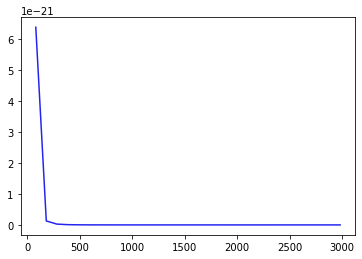

In [97]:
plt.plot(Ls, norm_x_norm)

In [103]:
kappa_k = ukappa_k * norm_k

In [111]:
Ls, kappa_cl = powspec_k(kappa_k, taper=taper, taper_order=0, modlmap=map_modlmap,\
                    lmin=Lmin, lmax=Lmax, delta_l=delta_L)

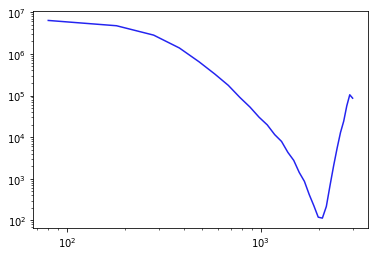

In [112]:
plt.plot(Ls, kappa_cl)
plt.xscale('log')
plt.yscale('log')